# Bias-Corrected Correlation Toolbox - Tutorial

This notebook demonstrates how to use the Bias-Corrected Correlation Toolbox for:

1. **Analyzing existing data** - Compute naive and corrected correlations with confidence intervals
2. **Planning future studies** - Simulate data to determine optimal sample sizes and measurement protocols

## Background

When measuring the correlation between two variables, measurement noise causes the observed correlation to underestimate the true correlation. This is called **attenuation**.

The classical correction formula (Spearman, 1904) is:

$$r_{corrected} = \frac{r_{observed}}{\sqrt{\text{reliability}_X \times \text{reliability}_Y}}$$

This toolbox helps you:
- Estimate reliability from test-retest measurements
- Apply the correction properly
- Quantify uncertainty via bootstrap confidence intervals
- Determine when correction is beneficial via simulation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

# Add toolbox to path (fill in the path to where you saved the toolbox)
sys.path.insert(0, 'Users/annabruns/Documents/~NYU/Research/Crowding/correlation/github/crowding-individual-difference/toolbox-and-tutorial')

# Import toolbox modules
from correlationToolbox import (
    # Core analysis
    TaskParameters,
    analyze_correlation,
    analyze_all_pairs,
    summarize_task_statistics,
    compute_reliability,
    
    # Simulation
    simulate_test_retest_data,
    run_simulation,
    run_simulation_grid,
    get_simulation_distributions,
    
    # Visualization
    set_publication_style,
    plot_correlation_heatmaps,
    plot_correlation_histograms,
    plot_rmse_comparison,
    plot_simulation_summary,
    plot_scatter_with_reliability,
)

# Set nice plot defaults
set_publication_style()
#np.random.seed(42)

---

# Part 1: Analyzing Existing Data

Use this workflow when you have collected data with test-retest measurements for multiple tasks.

## 1.1 Data Format

Your data should be organized as a DataFrame where:
- Each **row** is a subject
- Each **column** is a measurement
- Column names follow the pattern: `taskname_repeatN`

In [2]:
# Example: Create simulated data for demonstration
# In practice, you would load your own data: pd.read_csv('your_data.csv')
# You can also just estimate the parameters below from pilot data or past literature and use that to run the rest of the analysis

# Define task parameters (these would come from your actual measurements or past literature)
task1_params = TaskParameters(
    between_var=0.35,   # Variance between subjects (true individual differences)
    within_var=0.015,    # Variance within subjects (measurement noise)
    mean=-0.5,           # Mean value
    name='task1'
)

task2_params = TaskParameters(
    between_var=0.45,
    within_var=0.2,
    mean=2.9,
    name='task2'
)

# Simulate a dataset
demo_data = simulate_test_retest_data(
    task1_params, task2_params,
    n_subjects=60,
    n_repeats=4,
    true_correlation=0.5,
    random_state=None
)

print("Data shape:", demo_data.shape)
print("\nColumn names:")
print(demo_data.columns.tolist())
print("\nFirst 5 rows:")
demo_data.head()

Data shape: (60, 12)

Column names:
['task1_true', 'task2_true', 'task1_repeat1', 'task2_repeat1', 'task1_repeat2', 'task2_repeat2', 'task1_repeat3', 'task2_repeat3', 'task1_repeat4', 'task2_repeat4', 'task1_mean', 'task2_mean']

First 5 rows:


,task1_true,task2_true,task1_repeat1,task2_repeat1,task1_repeat2,task2_repeat2,task1_repeat3,task2_repeat3,task1_repeat4,task2_repeat4,task1_mean,task2_mean
0,-1.283403,3.555717,-1.419954,3.406177,-0.947510,3.124700,-1.411157,2.922096,-1.283233,3.750764,-1.265463,3.300934
1,-0.399787,3.422177,-0.395626,3.622164,-0.317335,2.946301,-0.373446,3.061783,-0.500706,4.955097,-0.396778,3.646336
2,0.176998,2.350180,0.248926,1.564835,-0.037762,1.955750,0.094543,2.622141,0.160993,1.679375,0.116675,1.955525
3,-0.733158,3.025670,-0.714501,3.203864,-0.819161,3.365893,-0.598716,3.026122,-0.779363,3.294497,-0.727936,3.222594
4,-0.630208,2.711977,-0.622648,3.696373,-0.585168,2.778891,-0.727100,1.872290,-0.559053,2.634759,-0.623492,2.745578


## 1.2 Single Pair Analysis

To analyze the correlation between two tasks:

In [3]:
# Extract measurements for each task
task1_measurements = demo_data[['task1_repeat1', 'task1_repeat2', 'task1_repeat3', 'task1_repeat4']]
task2_measurements = demo_data[['task2_repeat1', 'task2_repeat2', 'task2_repeat3', 'task2_repeat4']]

# Analyze correlation with bootstrap CIs
result = analyze_correlation(
    task1_measurements,
    task2_measurements,
    n_bootstrap=2000,      # More bootstrap samples = narrower CI estimates
    confidence_level=0.95,
    random_state=42
)

print(result)

Correlation Analysis Results (N=60)
Naive (uncorrected) r:     0.2496  95% CI: [0.012, 0.471]
Corrected r:               0.2646  95% CI: [0.012, 0.499]
Reliability X:             0.9870
Reliability Y:             0.9015
Attenuation factor:        0.9433



---

# Part 2: Planning Future Studies

Use this workflow to determine optimal sample sizes and measurement protocols.

In [2]:
# Define expected parameters for your planned study
planned_task1 = TaskParameters(
    between_var=0.35,
    within_var=0.06,
    mean=0.0,
    name='task1'
)

planned_task2 = TaskParameters(
    between_var=0.45,
    within_var=0.2,
    mean=0.0,
    name='task2'
)

print(f"Task 1 theoretical reliability: {planned_task1.reliability:.3f}")
print(f"Task 2 theoretical reliability: {planned_task2.reliability:.3f}")
print(f"Expected attenuation factor: {np.sqrt(planned_task1.reliability * planned_task2.reliability):.3f}")

Task 1 theoretical reliability: 0.854
Task 2 theoretical reliability: 0.692
Expected attenuation factor: 0.769


In [7]:
# Run simulation for a specific design and estimate of true correlation
true_correlation = 0.6
n_subjects = 60
n_repeats = 2

sim_result = run_simulation(
    planned_task1, planned_task2,
    n_subjects=n_subjects,
    n_repeats=n_repeats,
    true_correlation=true_correlation,
    n_iterations=1000,
    random_state=None
)

print(sim_result)

Simulation Results (N=60, repeats=2)
True correlation: 0.6000
Iterations: 1000

Naive Estimator:
  Mean: 0.5137  SD: 0.0959
  RMSE: 0.1290  95% CI: [0.304, 0.687]

Corrected Estimator:
  Mean: 0.5812  SD: 0.1053
  RMSE: 0.1069  95% CI: [0.348, 0.770]

Recommended estimator: Corrected



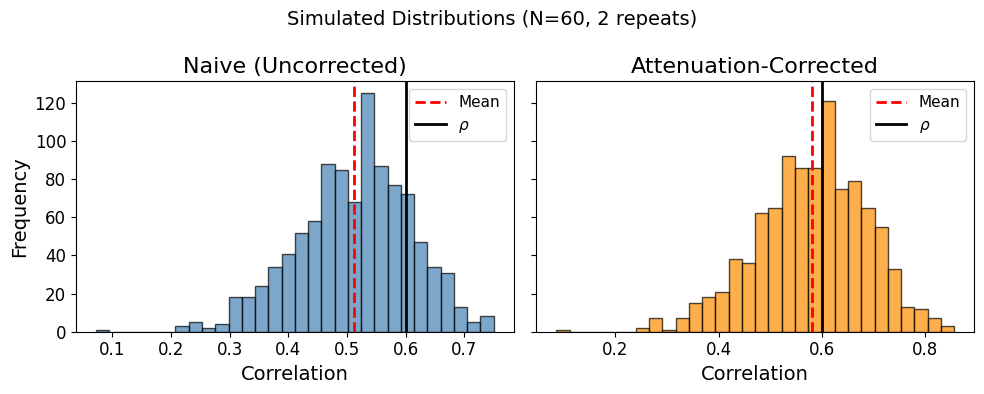

In [8]:
# Get distributions for visualization
distributions = get_simulation_distributions(
    planned_task1, planned_task2,
    n_subjects=n_subjects,
    n_repeats=n_repeats,
    true_correlation=true_correlation,
    n_iterations=1000,
    random_state=None
)

fig = plot_correlation_histograms(
    distributions['naive'],
    distributions['corrected'],
    true_correlation=true_correlation,
    title=f'Simulated Distributions (N={n_subjects}, {n_repeats} repeats)'
)
plt.show()

In [9]:
# Run grid search over design parameters
grid_results = run_simulation_grid(
    planned_task1, planned_task2,
    sample_sizes=[15, 30, 60, 120, 240],
    n_repeats_list=[2, 4, 6],
    true_correlation=true_correlation,
    n_iterations=500,
    random_state=None
)

print("\nSimulation Grid Results:")
grid_results.round(3)

Running condition 1/15: N=15, repeats=2
Running condition 2/15: N=15, repeats=4
Running condition 3/15: N=15, repeats=6
Running condition 4/15: N=30, repeats=2
Running condition 5/15: N=30, repeats=4
Running condition 6/15: N=30, repeats=6
Running condition 7/15: N=60, repeats=2
Running condition 8/15: N=60, repeats=4
Running condition 9/15: N=60, repeats=6
Running condition 10/15: N=120, repeats=2
Running condition 11/15: N=120, repeats=4
Running condition 12/15: N=120, repeats=6
Running condition 13/15: N=240, repeats=2
Running condition 14/15: N=240, repeats=4
Running condition 15/15: N=240, repeats=6

Simulation Grid Results:


,n_subjects,n_repeats,true_correlation,naive_mean,naive_sd,naive_rmse,naive_ci_lower,naive_ci_upper,corrected_mean,corrected_sd,corrected_rmse,corrected_ci_lower,corrected_ci_upper,recommended
0,15,2,0.6,0.514,0.204,0.221,0.051,0.833,0.587,0.231,0.231,0.063,0.953,Naive (uncorrected)
1,15,4,0.6,0.556,0.194,0.199,0.104,0.833,0.598,0.205,0.205,0.115,0.903,Naive (uncorrected)
2,15,6,0.6,0.560,0.191,0.195,0.109,0.839,0.589,0.199,0.199,0.118,0.881,Naive (uncorrected)
3,30,2,0.6,0.512,0.146,0.170,0.185,0.753,0.580,0.162,0.163,0.211,0.845,Corrected
4,30,4,0.6,0.542,0.140,0.151,0.222,0.764,0.582,0.147,0.149,0.242,0.810,Corrected
5,30,6,0.6,0.562,0.135,0.140,0.257,0.773,0.590,0.139,0.139,0.273,0.806,Corrected
6,60,2,0.6,0.513,0.098,0.131,0.300,0.685,0.580,0.109,0.111,0.344,0.777,Corrected
7,60,4,0.6,0.549,0.092,0.105,0.348,0.712,0.589,0.095,0.096,0.381,0.759,Corrected
8,60,6,0.6,0.571,0.088,0.093,0.385,0.730,0.599,0.091,0.091,0.406,0.759,Corrected
9,120,2,0.6,0.518,0.070,0.108,0.371,0.641,0.585,0.077,0.078,0.425,0.719,Corrected


/Users/annabruns/Documents/~NYU/Research/Crowding/correlation/github/crowding-individual-difference/toolbox-and-tutorial/correlationToolbox/visualization.py:500: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_numeric = pivot.applymap(lambda x: 1 if 'Corrected' in str(x) else 0)


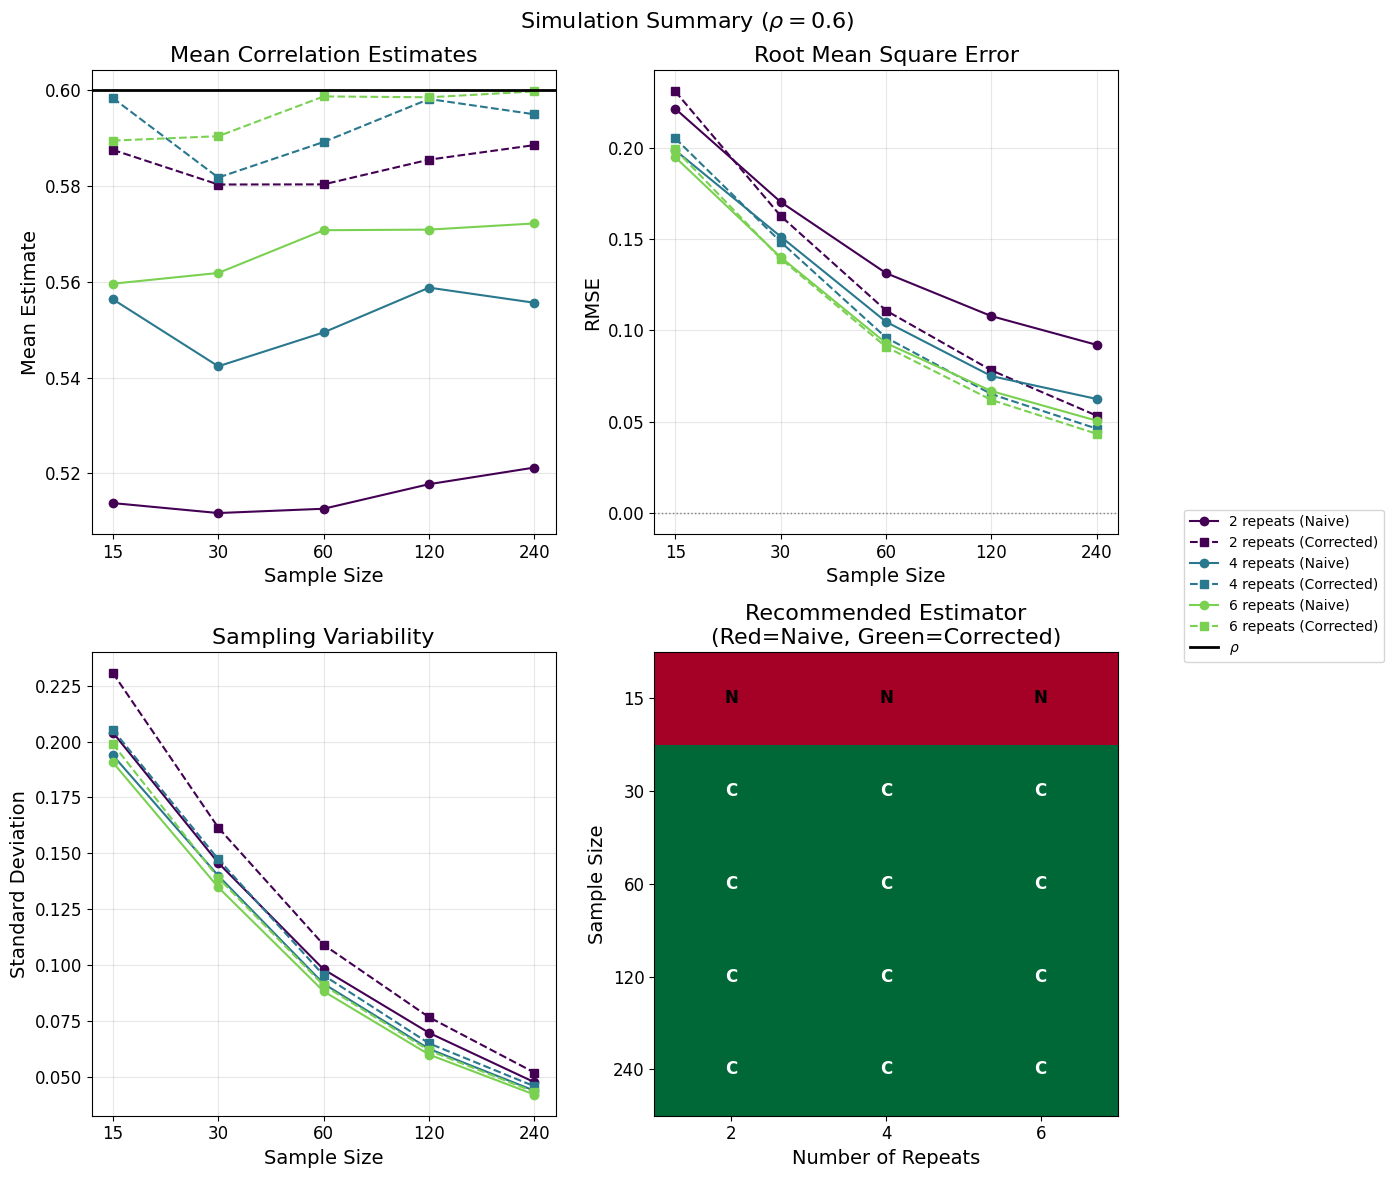

In [11]:
# Comprehensive summary plot
fig = plot_simulation_summary(grid_results, true_correlation=true_correlation)
plt.show()

---

# Summary

## Key Functions

| Function | Use Case |
|----------|----------|
| `analyze_correlation()` | Analyze single pair of tasks |
| `analyze_all_pairs()` | Analyze all pairwise correlations |
| `run_simulation()` | Evaluate estimators for specific design |
| `run_simulation_grid()` | Compare across multiple designs |
| `plot_correlation_heatmaps()` | Visualize naive vs. corrected |
| `plot_simulation_summary()` | Comprehensive simulation results |